In [1]:
from src.datamodules import ChesapeakeSpatialReasoningDataModule
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

In [2]:
dm = ChesapeakeSpatialReasoningDataModule(
    root="data/ChesapeakeSpatialReasoning/",
    batch_size=32,
    num_workers=8,
    differentiate_tree_canopy_over_roads=True,
)
dm.setup("fit")
dm.setup("validate")
dm.setup("test")

In [3]:
distances_to_roads_per_patch = []
for dl in [dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader()]:
    for batch in tqdm(dl):
        masks = batch["mask"]
        for i in range(masks.shape[0]):
            mask = masks[i].numpy()
            tree_canopy_over_road_mask = mask == 2
            if np.any(tree_canopy_over_road_mask):
                distance_to_road = cv2.distanceTransform((~(mask == 1)).astype(np.uint8), cv2.DIST_L1, 3)
                distances_from_tree_canopy_over_road_to_road = distance_to_road[tree_canopy_over_road_mask]
                distances_to_roads_per_patch.append(distances_from_tree_canopy_over_road_to_road)

100%|██████████| 94/94 [00:09<00:00,  9.49it/s]


In [4]:
all_distances_to_roads = np.concatenate(distances_to_roads_per_patch)

In [5]:
all_distances_to_roads = all_distances_to_roads[all_distances_to_roads < 8192.0]

In [6]:
mean = np.mean(all_distances_to_roads)
median = np.median(all_distances_to_roads)

In [7]:
np.percentile(all_distances_to_roads, 95), np.percentile(all_distances_to_roads, 98), np.percentile(all_distances_to_roads, 99)

(107.0, 202.0, 285.0)

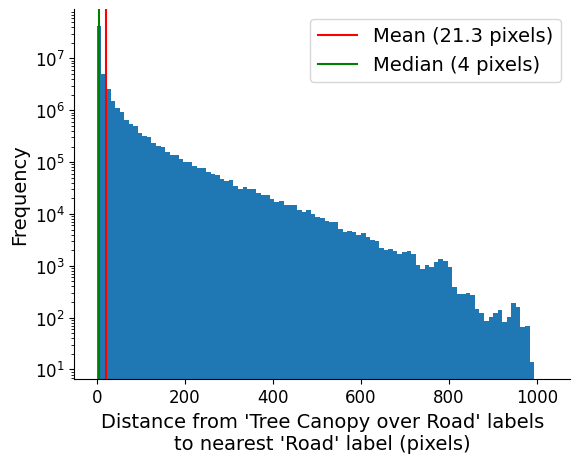

In [10]:
bins = np.linspace(0, 1024, 100)


fig = plt.figure()
ax = plt.gca()
plt.hist(all_distances_to_roads, bins=bins)
plt.yscale("log")
plt.xlabel("Distance from 'Tree Canopy over Road' labels\nto nearest 'Road' label (pixels)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# draw the mean and median lines
plt.axvline(mean, color="red", label=f"Mean ({mean:0.1f} pixels)")
plt.axvline(median, color="green", label=f"Median ({int(median):d} pixels)")
plt.legend(fontsize=14)
plt.show()
plt.close()